Comparison between perisistence diagram and the image

In [1]:
# Import libraries
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import gudhi
from tqdm import tqdm
from persim import PersistenceImager
import invr
import matplotlib as mpl
from PIL import Image
import io

In [2]:
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib default settings
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
# Utility functions
def get_folders(location):
    """Get list of folders in a directory."""
    return [name for name in os.listdir(location) if os.path.isdir(os.path.join(location, name))]

In [4]:
def generate_adjacent_counties(dataframe, variable_name):
    """Generate adjacent counties based on given dataframe and variable."""
    filtered_df = dataframe
    adjacent_counties = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')
    adjacent_counties = adjacent_counties.query('sortedID_left != sortedID_right')
    adjacent_counties = adjacent_counties.groupby('sortedID_left')['sortedID_right'].apply(list).reset_index()
    adjacent_counties.rename(columns={'sortedID_left': 'county', 'sortedID_right': 'adjacent'}, inplace=True)
    adjacencies_list = adjacent_counties['adjacent'].tolist()
    county_list = adjacent_counties['county'].tolist()
    merged_df = pd.merge(adjacent_counties, dataframe, left_on='county', right_on='sortedID', how='left')
    merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry')
    return adjacencies_list, merged_df, county_list

In [5]:
def form_simplicial_complex(adjacent_county_list, county_list):
    """Form a simplicial complex based on adjacent counties."""
    max_dimension = 3
    V = invr.incremental_vr([], adjacent_county_list, max_dimension, county_list)
    return V

In [6]:

def fig2img(fig):
     #convert matplot fig to image and return it

     buf = io.BytesIO()
     fig.savefig(buf)
     buf.seek(0)
     img = Image.open(buf)
     return img


In [14]:

def process_single_county(state, county_code, variable_name, selected_variables_with_censusinfo, base_path, PERSISTENCE_IMAGE_PARAMS, INFINITY,svi_path,generate_persistence_image=False):
    """Process data for a given state."""
    svi_od_path = os.path.join(data_path, state, state + '.shp')
    # svi_od = gpd.read_file(svi_path)
    svi_od = gpd.read_file(svi_od_path)


    
    svi_od_filtered_state = svi_od[selected_variables_with_censusinfo].reset_index(drop=True)
        
    # Filter the dataframe to include only the current county
    county_svi_df = svi_od_filtered_state[svi_od_filtered_state['STCNTY'] == county_code]

    # print('Number of census tracts in the county:', len(county_svi_df))

    
    list_gif = []

    df_one_variable = county_svi_df[['STCNTY', variable_name, 'geometry']]
    df_one_variable = df_one_variable.sort_values(by=variable_name)
    df_one_variable['sortedID'] = range(len(df_one_variable))
    df_one_variable = gpd.GeoDataFrame(df_one_variable, geometry='geometry')
    df_one_variable.crs = "EPSG:3395"
    adjacencies_list, adjacent_counties_df, county_list = generate_adjacent_counties(df_one_variable, variable_name)
    adjacent_counties_dict = dict(zip(adjacent_counties_df['county'], adjacent_counties_df['adjacent']))
    county_list = adjacent_counties_df['county'].tolist()
    simplices = form_simplicial_complex(adjacent_counties_dict, county_list)

    # diagram
    process_persistence_diagram_single_county(state, county_code, variable_name, selected_variables_with_censusinfo, base_path, PERSISTENCE_IMAGE_PARAMS, INFINITY,simplices,df_one_variable,generate_persistence_image=generate_persistence_image)

    # list_gif = plot_simplicial_complex(df_one_variable, simplices, variable_name,list_gif)
    # list_gif[0].save(f'{base_path}/{variable_name}_{county_code}.gif', save_all=True,append_images=list_gif[1:],optimize=False,duration=50,loop=0) #png also works


In [15]:
def process_persistence_diagram_single_county(state, county_code, variable_name, selected_variables_with_censusinfo, base_path, PERSISTENCE_IMAGE_PARAMS, INFINITY,simplices,df_one_variable,generate_persistence_image=False):

    try:
        """Process data for a given county and generate persistence diagram."""

        st = gudhi.SimplexTree()
        st.set_dimension(2)

        for simplex in simplices:
            if len(simplex) == 1:
                st.insert([simplex[0]], filtration=0.0)
        
        for simplex in simplices:
            if len(simplex) == 2:
                last_simplex = simplex[-1]
                filtration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                st.insert(simplex, filtration=filtration_value)

        for simplex in simplices:
            if len(simplex) == 3:
                last_simplex = simplex[-1]
                filtration_value = df_one_variable.loc[df_one_variable['sortedID'] == last_simplex, variable_name].values[0]
                st.insert(simplex, filtration=filtration_value)

        st.compute_persistence()
        persistence = st.persistence()

        intervals_dim1 = st.persistence_intervals_in_dimension(1)
        intervals_dim0 = st.persistence_intervals_in_dimension(0)


        # print("H0 Persistence points: ",len(intervals_dim0))
        # print("H1 Persistence points: ",len(intervals_dim1))

        # print("\n")
        # print("H0 Persistence intervals: ")
        # for birth, death in intervals_dim0:
        #         print(f"Birth: {birth}, Death: {death}")

        # print("\n")
        # print("H1 Persistence intervals: ")
        # for birth, death in intervals_dim1:
        #         print(f"Birth: {birth}, Death: {death}")
        
        # print("\n")
        

        pdgms = [[birth, death] for birth, death in intervals_dim1 if death < np.inf]

        # #add interval dim 0  to the pdgms
        # for birth, death in intervals_dim1:
        #     if death < np.inf:
        #         pdgms.append([birth, death])
        #     elif death == np.inf:
        #         pdgms.append([birth, INFINITY])


        if len(pdgms) > 0:
                    
            pimgr = PersistenceImager(pixel_size=0.01)

            if generate_persistence_image:
                    
                pimgr.fit(pdgms, skew=True)
                pimgr.pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size']
                pimgr.birth_range = PERSISTENCE_IMAGE_PARAMS['birth_range']
                pimgr.pers_range = PERSISTENCE_IMAGE_PARAMS['pers_range']
                pimgr.kernel_params = PERSISTENCE_IMAGE_PARAMS['kernel_params']


                pimgs = pimgr.transform(pdgms, skew=True)

                # plotting the persistence diagram and the persistence image
                fig, axs = plt.subplots(1, 3,figsize=(20, 10))

                axs[0].set_title("Original Diagram")
                pimgr.plot_diagram(pdgms, skew=False, ax=axs[0])

                axs[1].set_title("Birth-Persistence\nCoordinates")
                pimgr.plot_diagram(pdgms, skew=True, ax=axs[1])

                axs[2].set_title("Persistence Image")
                pimgr.plot_image(pimgs, ax=axs[2])

                plt.tight_layout()
                # plt.savefig(f'{base_path}/{variable_name}_{county_code}_comparison_scaled_1.png')
                plt.show()
                # plt.close()

        else:
            print("No persistence(without inf) for ", county_code)
    except Exception as e:
        print("Error in processing ", county_code, e)

Sigma: 0.0001


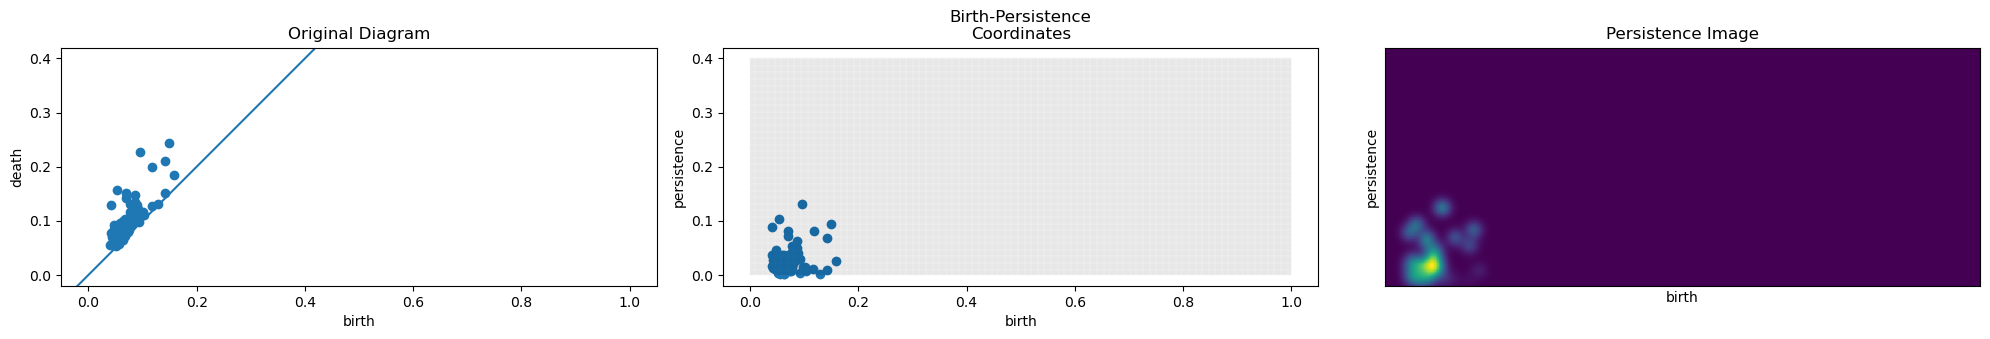

Sigma: 0.0002


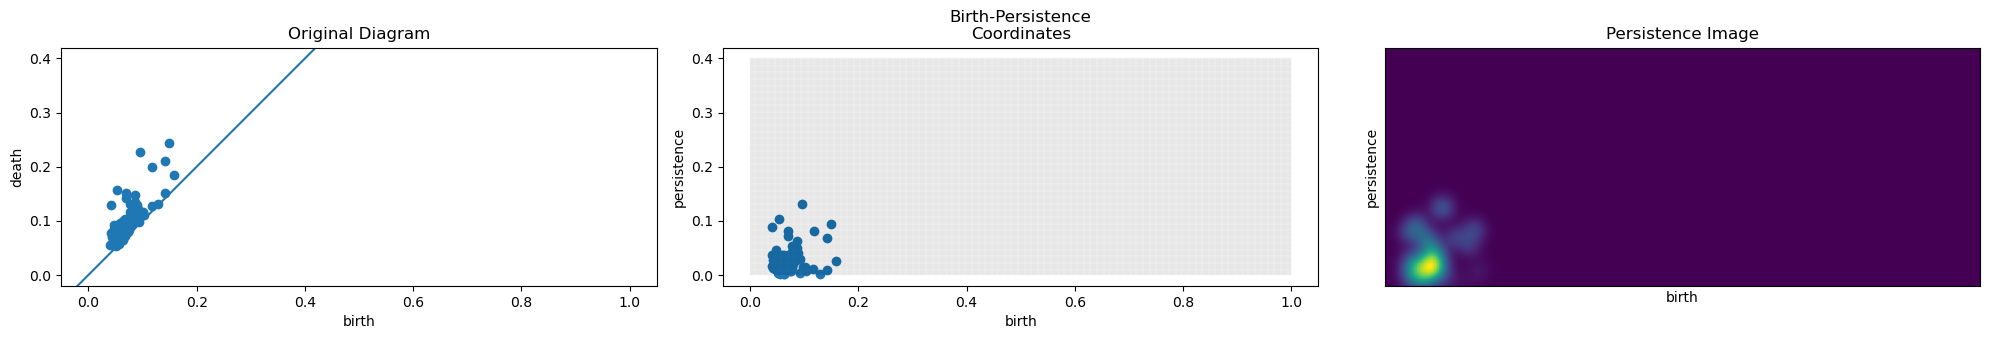

Sigma: 0.0003


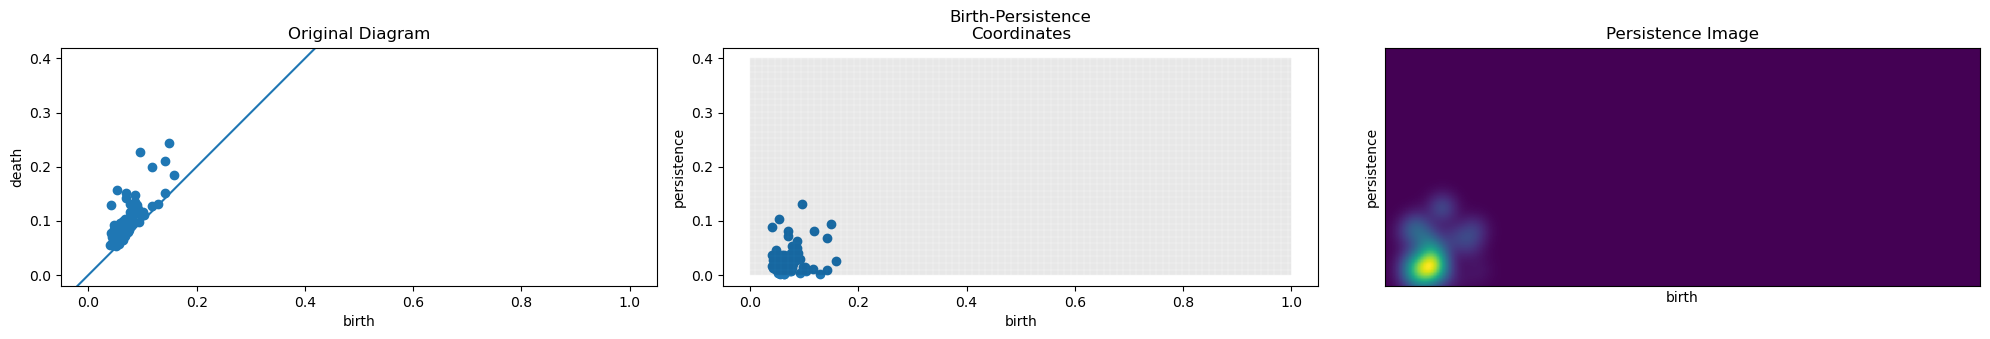

Sigma: 0.0005


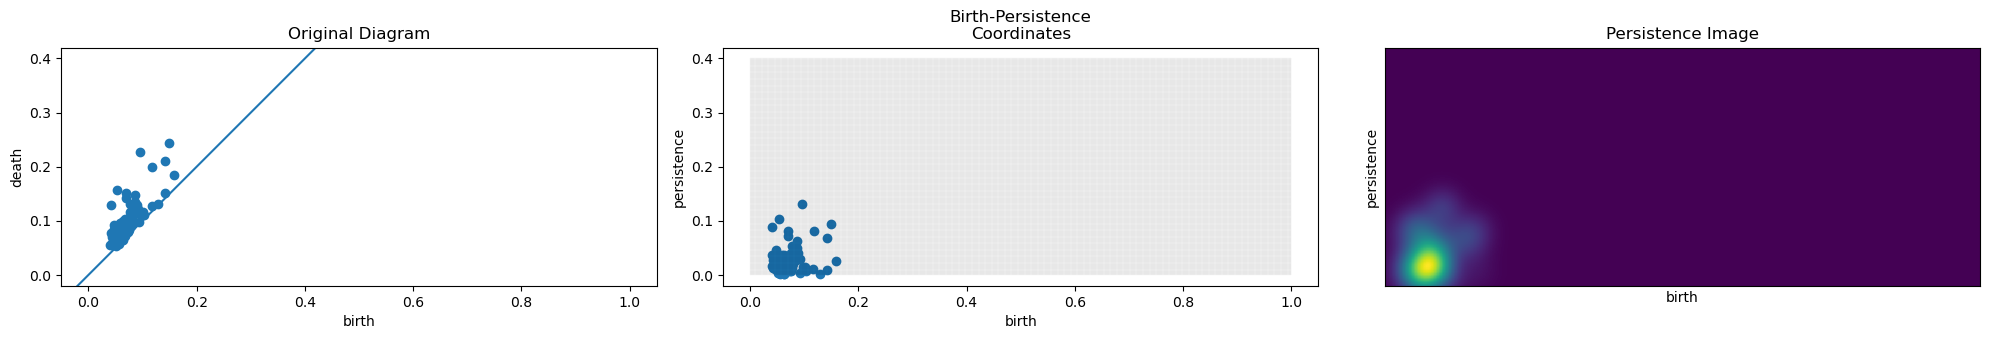

Sigma: 0.001


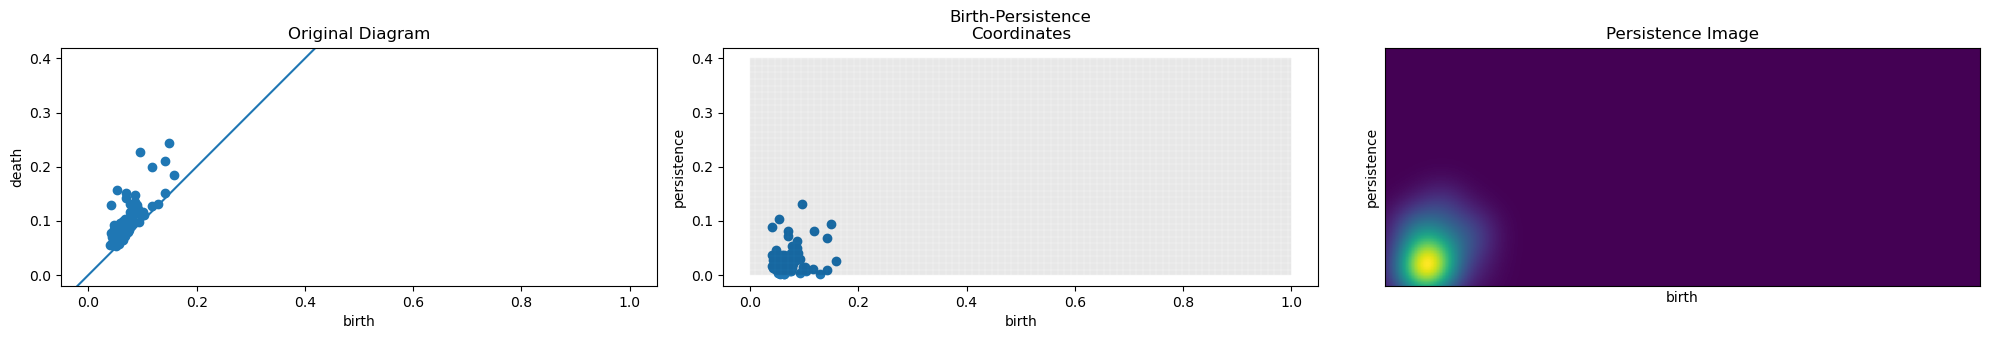

Sigma: 0.005


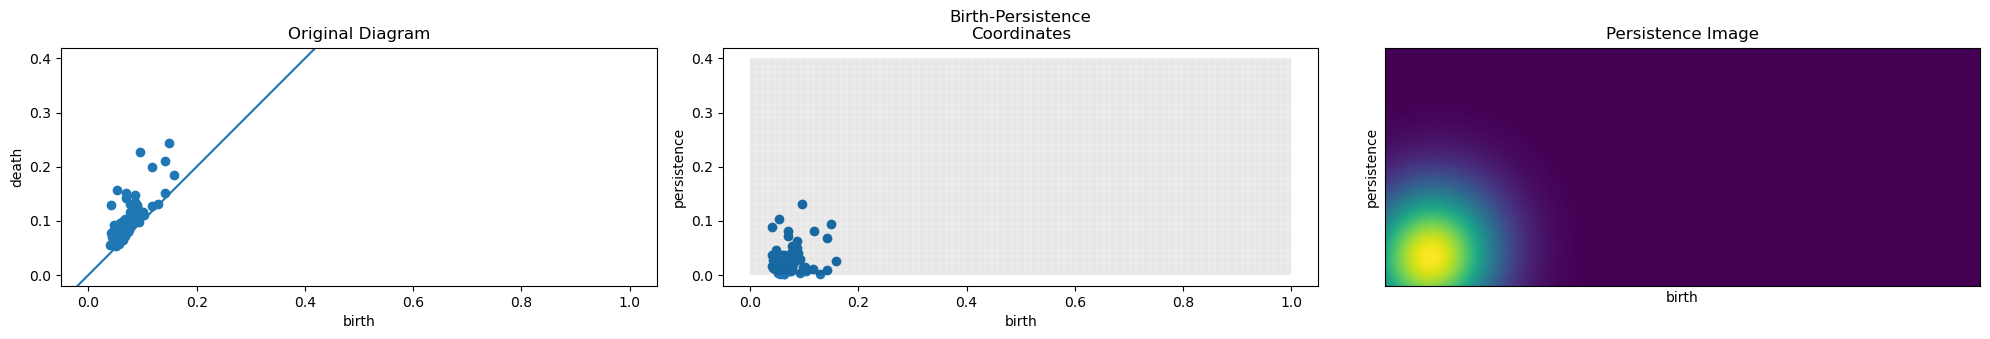

Sigma: 0.01


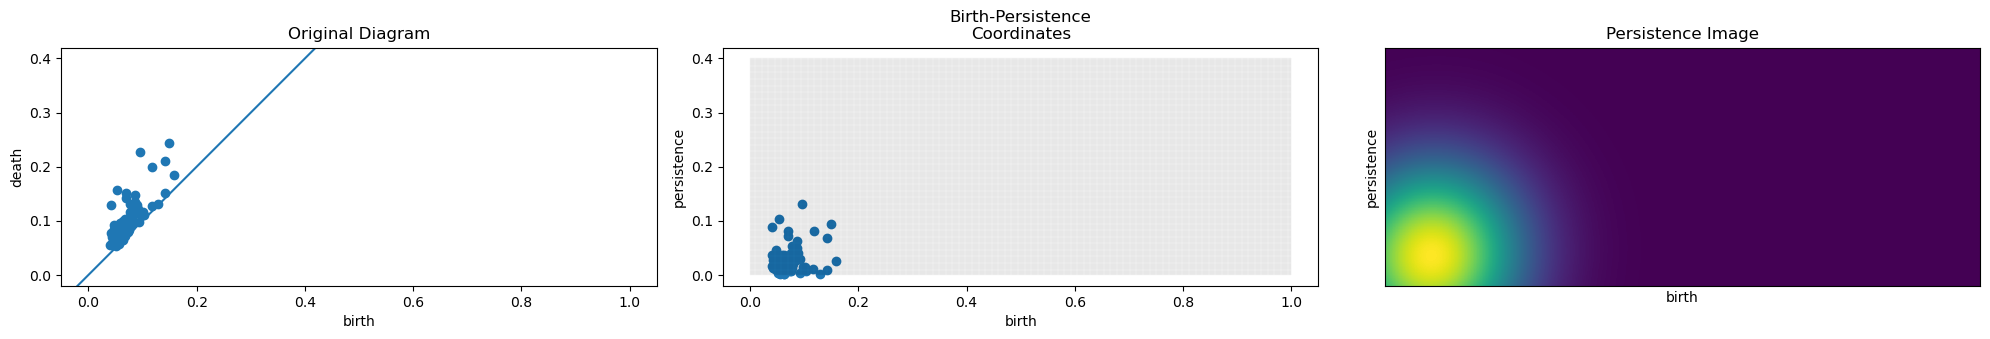

Sigma: 0.05


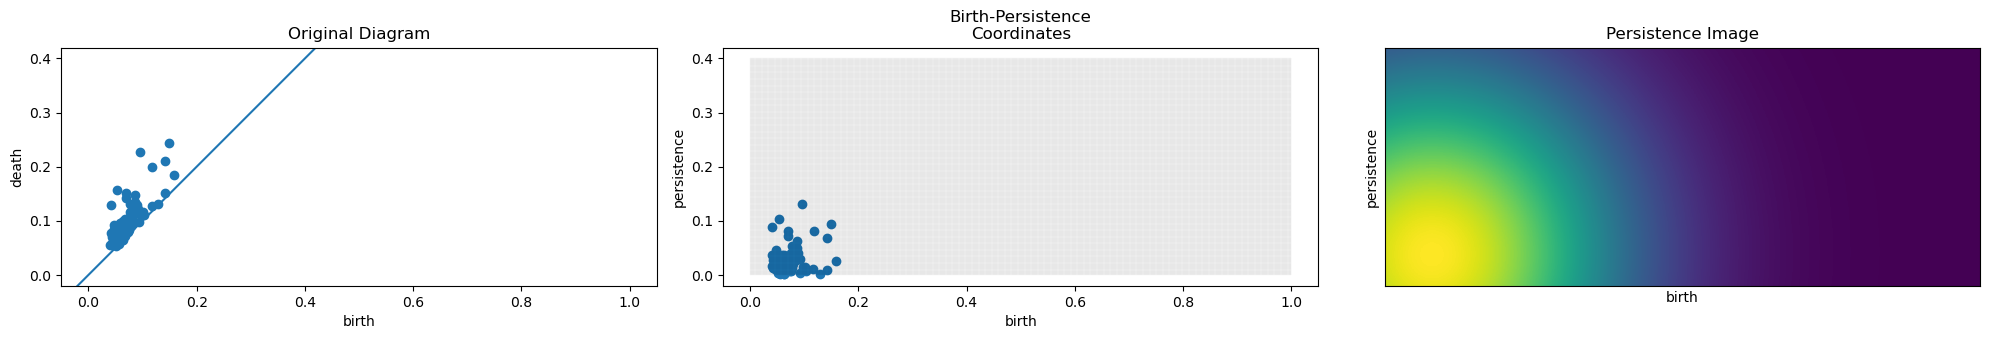

Sigma: 0.1


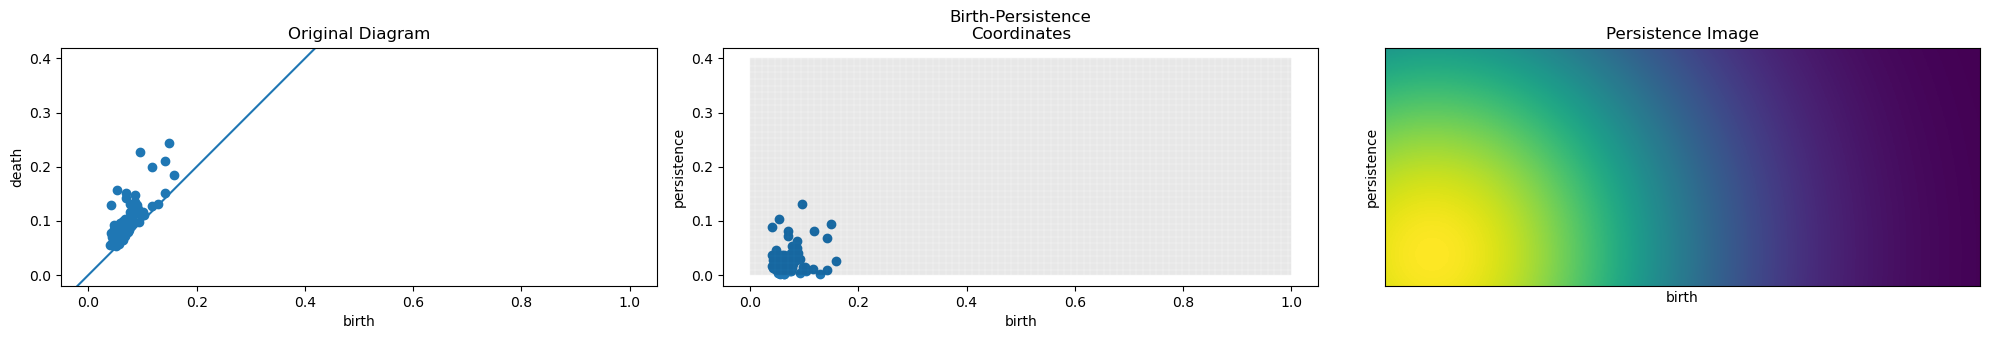

Sigma: 0.5


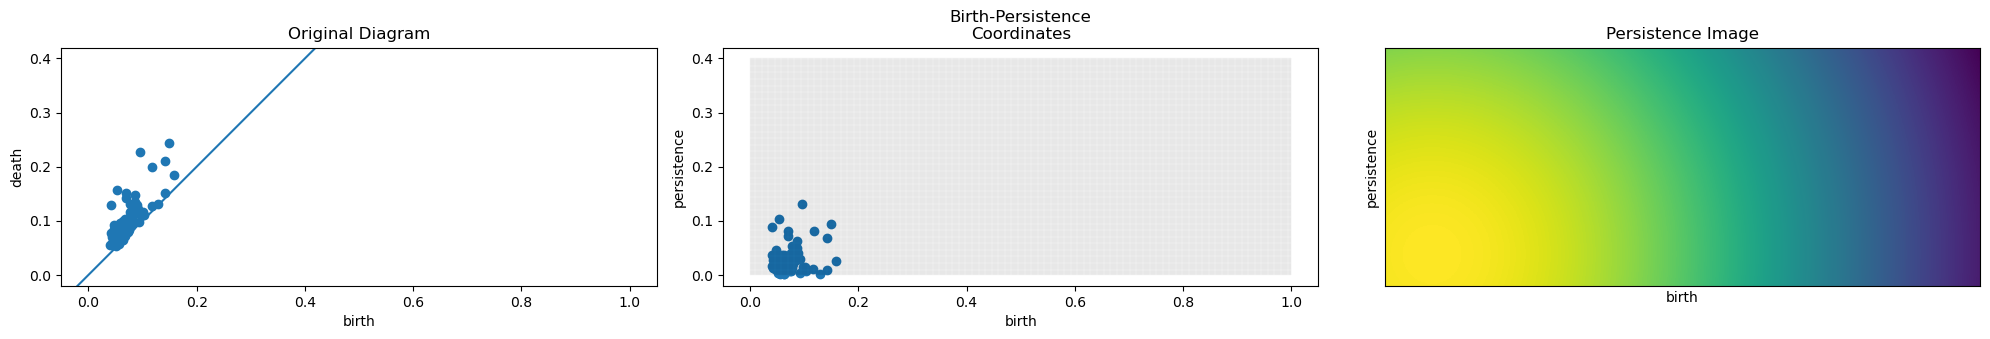

In [16]:
# Define the main function
if __name__ == "__main__":
    # Main execution
    base_path = '/home/h6x/git_projects/data_processing/processed_data/adjacency_pers_images_npy_county/comparison_experiments/single_county/experiment_1'
    data_path = '/home/h6x/Projects/data_processing/data/processed_data/SVI/SVI2018_MIN_MAX_SCALED_MISSING_REMOVED'

    # for unscaled data
    svi_path = '/home/h6x/Projects/overdose_modeling/data/svi/2018/SVI2018_US_tract.gdb'

    states = get_folders(data_path)
    selected_variables = [
        'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 
        'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ'
    ]
    selected_variables_with_censusinfo = ['FIPS', 'STCNTY'] + selected_variables + ['geometry']

    PERSISTENCE_IMAGE_PARAMS = {
        'pixel_size': 0.001,
        'birth_range': (0.0, 1.00),
        'pers_range': (0.0, 0.40),
        'kernel_params': {'sigma': 0.0005}
    }

    INF_DELTA = 0.1
    # INFINITY = (PERSISTENCE_IMAGE_PARAMS['birth_range'][1] - PERSISTENCE_IMAGE_PARAMS['birth_range'][0]) * INF_DELTA
    INFINITY = 1.0

    # Uncomment this if you want to process a single county
    state = 'NY'
    county_code = '36081'
    variable = 'EP_UNEMP'

    generate_persistence_image=True


    experiment_sigma = [0.0001,0.0002,0.0003,0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]


    for sigma in experiment_sigma:

        PERSISTENCE_IMAGE_PARAMS = {
            'pixel_size': 0.001,
            'birth_range': (0.0, 1.00),
            'pers_range': (0.0, 0.40),
            'kernel_params': {'sigma': sigma}
        }

        # print(f"Processing {state} - {county_code} - {variable} - sigma: {sigma} - pixel_size: {PERSISTENCE_IMAGE_PARAMS['pixel_size']}")
        print(f"Sigma: {sigma}")

        process_single_county(state, county_code, variable, selected_variables_with_censusinfo, base_path, PERSISTENCE_IMAGE_PARAMS, INFINITY,svi_path,generate_persistence_image)

